## Game Summary Dashboards

This notebook outlines how one can generate a dashboard-style visualization of shot attempts for two teams in a given game. This involves querying relevant data from the MongoDB database, transforming the data to align all shots for one team to have the same 'directionality' (i.e.: shooting the same direction), and then generating the summary statistics. 

The game summary visualization includes a map of all shots on target, missed shots, and goals overlaid on the rink. It also includes additional summary statistics such as goals, shots on target, missed shots, blocked shots, 'high danger shots', giveaways, takeaways, powerplays and powerplay percentage.

---

#### Analysis notes: 

Shot recording:

To standardize the dashboard and make the results more interpretable, I have designed it so the home team shots are always shown on the left side of the rink, and away team shots on the right side. However, due to the lack of standardization in home-away shot recording conventions, the initial side of the ice where the home team shoots varies between rinks and requires some cleaning of the data. Moreover, the side of the rink changes between the 1st and 2nd periods and so these shots need to be mirrored to the all lie on the same end of the rink. 

Computing high danger chances:

Note that 'high danger' shots are those taken from within the 'homeplate' area on the rink, which encloses the area extending out from the sides of the crease, to the faceoff dot centers, and within the tops of the circles (see graphic in notebook). To calculate which shots lie within this region, I define a polygon path based on coordinates of the edges of the home plate region. I can then use path.contains to create a boolean mask of shots that fall within or outside and sum the results.







In [1]:
# first install dnspython3, then uninstall dnspython, then install dnspython=2.1.0
# (otherwise keyword error with pymongo)
# solution from https://github.com/dcrosta/flask-pymongo/issues/133
! python3 -m pip install dnspython3
! python3 -m pip uninstall dnspython
! python3 -m pip install dnspython==2.1.0
# Instaling PyMongo, this is the interface to connect to MongoDB with Python
! python3 -m pip install pymongo==3.11.1

  Using cached dnspython-1.15.0-py2.py3-none-any.whl (177 kB)
  Attempting uninstall: dnspython
    Found existing installation: dnspython 2.1.0
    Uninstalling dnspython-2.1.0:
      Successfully uninstalled dnspython-2.1.0
Found existing installation: dnspython 1.15.0
Uninstalling dnspython-1.15.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/dns/*
    /usr/local/lib/python3.7/dist-packages/dnspython-1.15.0.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled dnspython-1.15.0
  Using cached dnspython-2.1.0-py3-none-any.whl (241 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dnspython3 1.15.0 requires dnspython==1.15.0, but you have dnspython 2.1.0 which is incompatible.


In [2]:
import pymongo
from pymongo import MongoClient
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import pandas as pd
import certifi
from matplotlib.path import Path

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/hockey_analytics')
import config

# define path to background images
fig_dir = '/content/drive/MyDrive/hockey_analytics/figures'

# define path to background images
bg_filename = 'full_ice_scale_mm.png'
bg_path = os.path.join(fig_dir,bg_filename)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# connect to mongodb database

uri = config.mongoDB_uri
client = MongoClient(uri, tlsCAFile=certifi.where())
events = client.game_events
rs1920_plays = events.rs_1920_plays
rs1920_boxscores = events.rs_1920_boxscores

# define game to extract
game = 2019020001

In [4]:
# define query to extract game shots and information
pipeline = [{'$unwind': '$allPlays'},
            {'$project': {
                'event': '$allPlays.result.event',
                'primary_player': { '$arrayElemAt': [ '$allPlays.players.player.fullName' , 0 ] },
                'x': '$allPlays.coordinates.x',
                'y': '$allPlays.coordinates.y',
                'team': '$allPlays.team.triCode',
                'period': '$allPlays.about.period'
                }
            },
            {'$match': {
                '$and': [
                    {
                    '$or': [
                        {'event': 'Shot'},
                        {'event': 'Missed Shot'},
                        {'event': 'Goal'}
                        ]
                    },
                    {'_id': game}
                    ]
                }
            }
            ]

query_shots = list(rs1920_plays.aggregate(pipeline))

pipeline = [{'$match': {'_id': game}},
            {'$lookup':
                 {
                     'from': 'rs_1920_info',
                     'let': {'curr_game': "$_id"},
                     'pipeline': [
                         {'$match': {
                             '$expr': {'$eq': ['$_id', '$$curr_game']}
                             }
                         },
                         {'$project': {
                             'home': '$teams.home.triCode',
                             'away': '$teams.away.triCode',
                             'date': '$datetime.dateTime',
                             'venue': '$venue.name'
                             }
                         }
                     ],
                     'as': 'info'
                 }
             },
            {'$project': {
                '_id': 1,
                'home': '$info.home',
                'away': '$info.away',
                'date': '$info.date',
                'venue': '$info.venue',
                'home_stats': '$teams.home.teamStats.teamSkaterStats',
                'away_stats': '$teams.away.teamStats.teamSkaterStats'
                }
            },
            {'$limit': 3}
            ]
    
query_info = list(rs1920_boxscores.aggregate(pipeline))

# convert shots to data frame for transformations
df_shots = pd.DataFrame(query_shots)

In [5]:
# show first few rows of shots dataframe
df_shots.head(5)

#print(query_info[0])

,_id,event,primary_player,x,y,team,period
0,2019020001,Goal,Brady Tkachuk,85.0,-1.0,OTT,1
1,2019020001,Missed Shot,Nikita Zaitsev,28.0,-37.0,OTT,1
2,2019020001,Shot,Morgan Rielly,-32.0,-2.0,TOR,1
3,2019020001,Missed Shot,Mitchell Marner,-46.0,-16.0,TOR,1
4,2019020001,Missed Shot,Dmytro Timashov,-64.0,-4.0,TOR,1


In [6]:
#%% transform data to show home and away shots on different ends of ice
'''
NOTES:
    home: shooting on right first, away: shooting on left first
    - show shots from first period orientation (shots taken not conceeded)
    - flip coordinates:
        - home: P2
        - away: P2
'''
# transform coordinates to have all shots on same side for each team
df_shots.loc[df_shots.period == 2, ['x','y']] *= -1

home_team = query_info[0]['home'][0]
away_team = query_info[0]['away'][0]

# separate shots on target, goals and missed shots for each 
# ----- home -----
home_goals = df_shots.loc[
    ((df_shots['team'] ==  home_team) & 
     (df_shots['event'] == 'Goal')), 
    ['x','y']
    ]

home_missed = df_shots.loc[
    ((df_shots['team'] ==  home_team) & 
     (df_shots['event'] == 'Missed Shot')), 
    ['x','y']
    ]

home_shots = df_shots.loc[
    ((df_shots['team'] ==  home_team) & 
     (df_shots['event'] == 'Shot')), 
    ['x','y']
    ]
# ----- away -----
away_goals = df_shots.loc[
    ((df_shots['team'] ==  away_team) & 
     (df_shots['event'] == 'Goal')), 
    ['x','y']
    ]

away_missed = df_shots.loc[
    ((df_shots['team'] ==  away_team) & 
     (df_shots['event'] == 'Missed Shot')), 
    ['x','y']
    ]

away_shots = df_shots.loc[
    ((df_shots['team'] ==  away_team) & 
     (df_shots['event'] == 'Shot')), 
    ['x','y']
    ]

# check for switched home-away orientation
# home shots and goals always shown on left
if home_shots['x'].mean() > 0:
    # shots shown on opposite side of rink so reflect x and y about origin
    home_shots = -1*home_shots
    home_missed = -1*home_missed
    home_goals = -1*home_goals
    
    away_shots = -1*away_shots
    away_missed = -1*away_missed
    away_goals = -1*away_goals
    
# assign queries to home and away stats to variable for easier calls
home_query = query_info[0]['home_stats']
away_query = query_info[0]['away_stats']

In [7]:
# define high danger area on the rink and compute shot totals within for each team
verts = [
   (54, 24),  # left, bottom
   (68, 24),  # left, top
   (89, 9.5),  # right, top
   (89, -9.5),  # right, bottom
   (68, -24),
   (54,-24),
   (54, 24)# ignored
]

codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,
]

path = Path(verts, codes)


home_high_danger = home_shots.apply(lambda r: 1 if path.contains_point((np.abs(r.x), r.y)) else 0, axis= 1).sum()
away_high_danger = away_shots.apply(lambda r: 1 if path.contains_point((np.abs(r.x), r.y)) else 0, axis= 1).sum()

In [8]:
# define summary stats
game_summary = {'goals': home_query['goals'] + away_query['goals'],
                'shots': home_query['shots'] + away_query['shots'],
                'high_danger_shots' : home_high_danger + away_high_danger,
                'hits': home_query['hits'] + away_query['hits'],
                'blocked': home_query['blocked'] + away_query['blocked'],
                'giveaways': home_query['giveaways'] + away_query['giveaways'],
                'takeaways': home_query['takeaways'] + away_query['takeaways'],
                'powerplays': home_query['powerPlayOpportunities'] + away_query['powerPlayOpportunities']
                }

h_stats = [0,
           home_query['powerPlayOpportunities']/game_summary['powerplays'],
           home_query['takeaways']/game_summary['takeaways'],
           home_query['giveaways']/game_summary['giveaways'],
           float(home_query['faceOffWinPercentage'])/100,
           home_query['blocked']/game_summary['blocked'],
           home_query['hits']/game_summary['hits'],
           home_high_danger/game_summary['high_danger_shots'],
           home_query['shots']/game_summary['shots']]

a_stats = [0,
           away_query['powerPlayOpportunities']/game_summary['powerplays'],
           away_query['takeaways']/game_summary['takeaways'],
           away_query['giveaways']/game_summary['giveaways'],
           float(away_query['faceOffWinPercentage'])/100,
           away_query['blocked']/game_summary['blocked'],
           away_query['hits']/game_summary['hits'],
           away_high_danger/game_summary['high_danger_shots'],
           away_query['shots']/game_summary['shots']
           ]

a_stats_val = [round(float(away_query['powerPlayPercentage']),0),
           int(away_query['powerPlayOpportunities']),
           away_query['takeaways'],
           away_query['giveaways'],
           away_query['faceOffWinPercentage'],
           away_query['blocked'],
           away_query['hits'],
           away_high_danger,
           away_query['shots']
           ]

findfont: Font family ['Avenir LT Std'] not found. Falling back to DejaVu Sans.


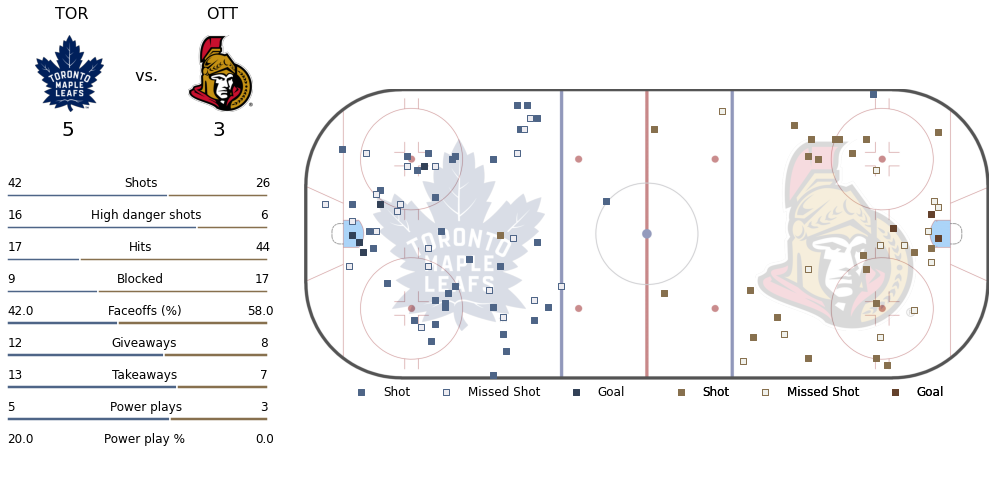

In [9]:
#%% GENERATE FIG
#plt.close('all')

#plt.style.use('C:/Users/Jared/Documents/hockey_statistics/python/stg_plot_style_1.mplstyle')
plt.rcParams['font.family'] = 'Sans Serif'
plt.rcParams['font.style'] = 'normal'
plt.rcParams['font.variant'] = 'normal'
plt.rcParams['font.weight'] = 'light'
plt.rcParams['font.stretch'] = 'normal'
plt.rcParams['font.size'] = 12

# define paths to logo
logo_home_filename = home_team.lower()+'_logo_nhl.png'
logo_away_filename = away_team.lower()+'_logo_nhl.png'

logo_home_path = os.path.join(fig_dir,logo_home_filename)
logo_away_path = os.path.join(fig_dir,logo_away_filename)

# load images
img_bg = plt.imread(bg_path)
home_logo = plt.imread(logo_home_path)
away_logo = plt.imread(logo_away_path)

# calculate logo extents for plotting
if np.argmax(home_logo.shape) == 0:
    scale = home_logo.shape[0]/56
    t, b = 28,-28
    l, r = -55 - home_logo.shape[1]/scale/2, -55 + home_logo.shape[1]/scale/2
else:
    scale = home_logo.shape[1]/56
    l, r = -85, -29
    t, b = home_logo.shape[0]/scale/2, -home_logo.shape[0]/scale/2
    
extent_home_logo = [l,r,b,t]

if np.argmax(away_logo.shape) == 0:
    scale = away_logo.shape[0]/56
    t, b = 28,-28
    l, r = 55 - away_logo.shape[1]/scale/2, 55 + away_logo.shape[1]/scale/2
else:
    scale = away_logo.shape[1]/56
    r, l = 85, 29
    t, b = away_logo.shape[0]/scale/2, - away_logo.shape[0]/scale/2
    
extent_away_logo = [l,r,b,t]
marker = 's'
shot_ms = 45 # shot marker size

home_plate_coords = {'x': [54, 54, 68, 89, 89, 68],
                     'y': [-24, 24, 24, 9.5, -9.5, -24]}

# list of hex colors for shots, missed shots and goals in that order
# ----- home -----
c_h = ['#4E6587', '#EDECF1', '#324157']
ec_h = ['#4E6587', '#4E6587', '#324157']
# ---- away -----
c_a = ['#87704E', '#F0F1EC', '#64412B']
ec_a = ['#87704E','#87704E', '#64412B']

# define text margins for bar chart labels - away stats to right align
def set_right_text_margin(x):
    if x == 2:
        return 0.95
    elif x == 3:
        return 0.92
    else:
        return 0.97

# length of numbers for each stat
len_a_stats = [len(str(x)) for x in a_stats_val] 
# remove character from decimals
len_a_stats[0] -= 1
len_a_stats[4] -= 1
# define list of margins for each entry
a_margin = list(map(set_right_text_margin, len_a_stats))   
#%%
plt.close('all')
# define plot parameters/variables
labels = list(np.linspace(0, (len(h_stats)-1)*0.7, len(h_stats)))
index = np.arange(len(labels))
width = 0.08 # bar width

# dimensions of grid spec axes
widths = [4, 10]
heights = [2, 4]

# rink extents
rink_bg_extents = [-100, 100, -42.5, 42.5]

# ----- generate 'dshboard-style' figure -----
f = plt.figure(figsize = (14,7), constrained_layout=False)
gs = f.add_gridspec(2, 2, width_ratios = widths, height_ratios = heights)

ax_b = f.add_subplot(gs[1,0])
ax_b.barh(labels, h_stats, width, color = ec_h[1], ec = '#FFFFFF', linewidth = 1.5, label = 'HOME')
ax_b.barh(labels, a_stats, width, color = ec_a[1], ec = '#FFFFFF', linewidth = 1.5, left = h_stats, label = 'AWAY')
ax_b.axes.xaxis.set_visible(False)
ax_b.axes.yaxis.set_visible(False)
ax_b.set_ylim([-0.5,len(h_stats)*0.7])
ax_b.spines['right'].set_visible(False)
ax_b.spines['top'].set_visible(False)
ax_b.spines['left'].set_visible(False)
ax_b.spines['bottom'].set_visible(False)

# ----- annotate -----
# values (bottom up)
ax_b.annotate(str(round(float(home_query['powerPlayPercentage']),0)),(0.0, 0.2))
ax_b.annotate(str(round(float(away_query['powerPlayPercentage']),0)),(a_margin[0], 0.2))
ax_b.annotate(str(int(home_query['powerPlayOpportunities'])),(0.0, 0.9))
ax_b.annotate(str(int(away_query['powerPlayOpportunities'])),(a_margin[1], 0.9))
ax_b.annotate(str(home_query['takeaways']),(0.0, 1.6))
ax_b.annotate(str(away_query['takeaways']),(a_margin[2], 1.6))
ax_b.annotate(str(home_query['giveaways']),(0.0, 2.3))
ax_b.annotate(str(away_query['giveaways']),(a_margin[3], 2.3))
ax_b.annotate(str(round(float(home_query['faceOffWinPercentage']),0)),(0.0, 3.0))
ax_b.annotate(str(round(float(away_query['faceOffWinPercentage']),0)),(a_margin[4], 3.0))
ax_b.annotate(str(home_query['blocked']),(0.0, 3.7))
ax_b.annotate(str(away_query['blocked']),(a_margin[5], 3.7))
ax_b.annotate(str(home_query['hits']),(0.0, 4.4))
ax_b.annotate(str(away_query['hits']),(a_margin[6], 4.4))
ax_b.annotate(str(home_high_danger),(0.0, 5.1))
ax_b.annotate(str(away_high_danger),(a_margin[7], 5.1))
ax_b.annotate(str(home_query['shots']),(0.0, 5.8))
ax_b.annotate(str(away_query['shots']),(a_margin[8], 5.8))

# labels (bottom up)
ax_b.annotate('Power play %', (0.37, 0.2))
ax_b.annotate('Power plays', (0.395, 0.9))
ax_b.annotate('Takeaways', (0.40, 1.6))
ax_b.annotate('Giveaways', (0.40, 2.3))
ax_b.annotate('Faceoffs (%)', (0.385, 3.0))
ax_b.annotate('Blocked', (0.42, 3.7))
ax_b.annotate('Hits', (0.465, 4.4))
ax_b.annotate('High danger shots', (0.32, 5.1))
ax_b.annotate('Shots', (0.45, 5.8))

# plot goals overlaid on rink
ax_m = f.add_subplot(gs[:, 1])
ax_m.imshow(img_bg, extent = rink_bg_extents)
ax_m.scatter(
    home_shots['x'], home_shots['y'], marker = marker, s = shot_ms,
    c = c_h[0], edgecolors = ec_h[0], alpha = 1, label = 'Shots'
    )
ax_m.scatter(
    home_missed['x'], home_missed['y'], marker = marker, s = shot_ms,
    c = c_h[1], edgecolors = ec_h[1], alpha = 1, label = 'Missed Shots'
    )
ax_m.scatter(
    home_goals['x'], home_goals['y'], marker = marker, s = shot_ms,
    c = c_h[2], edgecolors = ec_h[2], alpha = 1, label = 'Goals'
    )
ax_m.scatter(
    away_shots['x'], away_shots['y'], marker = marker, s = shot_ms,
    c = c_a[0], edgecolors = ec_a[0], alpha = 1, label = 'Shots'
    )
ax_m.scatter(
    away_missed['x'], away_missed['y'], marker = marker, s = shot_ms,
    c = c_a[1], edgecolors = ec_a[1], alpha = 1, label = 'Missed Shots'
    )
ax_m.scatter(
    away_goals['x'], away_goals['y'], marker = marker,  s= shot_ms,
    c = c_a[2], edgecolors = ec_a[2], alpha = 1, label = 'Goals'
    )
ax_m.imshow(home_logo, extent = extent_home_logo, alpha = 0.15)
ax_m.imshow(away_logo, extent = extent_away_logo, alpha = 0.15)
ax_m.set_aspect(1)
ax_m.set(xlim=(-100, 100), ylim=(-42.5, 42.5))
ax_m.axis('off')

# legend for home and away
children = ax_m.get_children()
legend1 = plt.legend([children[i] for i in [0,1,2]], 
                     ['Shot', 'Missed Shot', 'Goal'], loc=3, 
                     bbox_to_anchor=(0.05, -0.1), frameon = False, 
                     fancybox = False, ncol = 3)
legend2 = plt.legend([children[i] for i in [3,4,5]], 
                     ['Shot', 'Missed Shot', 'Goal'], 
                     loc=4, bbox_to_anchor=(0.95, -0.1), 
                     frameon = False, fancybox = False, ncol = 3,
                     prop={'family':'Avenir LT Std', 'style': 'normal', 'weight':'light'})
ax_m.add_artist(legend1)
plt.setp(legend2.texts, family='Avenir LT Std')
ax_m.add_artist(legend2)

# add scores, logos, game info
ax_s = f.add_subplot(gs[0,0])
ax_s.set_aspect(1)
ax_s.set(xlim=(-100, 100), ylim=(-42.5, 42.5))
ax_s.imshow(home_logo, extent = extent_home_logo, alpha = 1)
ax_s.imshow(away_logo, extent = extent_away_logo, alpha = 1)
ax_s.axes.xaxis.set_visible(False)
ax_s.axes.yaxis.set_visible(False)
ax_s.spines['right'].set_visible(False)
ax_s.spines['top'].set_visible(False)
ax_s.spines['left'].set_visible(False)
ax_s.spines['bottom'].set_visible(False)

#Add text to figure:
ax_s.text(-65, 40, home_team, fontsize=16)
ax_s.text(-10, -5, ' vs. ', fontsize=16)
ax_s.text(45, 40, away_team, fontsize=16)
ax_s.text(50, -45, away_query['goals'], fontsize=20)
ax_s.text(-60, -45, home_query['goals'], fontsize=20)


plt.tight_layout()
plt.show()

